In [2]:
# Imports and path definitions

import sys
import os
import plotly.plotly as py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import combinations
import scipy

path = os.getcwd() + '/'

In [3]:
#
##
### Functions
##
#
def pend(l_real, l_imag, l_projections, n):
    g = float(7)/6
    beta = 0.46686
    l_mj = []
    
    for i in l_projections:
        vec = i.split('/')
        l_mj.append(float(vec[0]))
    l = list(range(0,n))
    coef_l = []
    
    for i in l:
        x = complex(float(l_real[i]), float(l_imag[i]))    # complex
        coef_i = g*beta*(abs(x)**2)*l_mj[i]  # complex
        coef_l.append(coef_i)
    coef = sum(coef_l)
    
    return coef#, coef_l


def compare_pend(d_pends, d_eigenvectors): #d_eigenvalues
    d_dif = {}
    d_uniq = {}
    lim = 10**(-3)
    
        
    for a, b in combinations(d_pends, 2):
        #difE != 0
        # continue
        if d_eigenvectors[a] != d_eigenvectors[b]:
            value = abs(d_pends[a]- d_pends[b])

            if value < lim:
                d_dif[a + b] = value
    
    return d_dif


def sderivative(pend1, pend2, field1, field2):
    value = (float(pend1) - float(pend2)) / (float(campo1) - float(pend2))


In [86]:
##### Run at the same folder as simpre calculation (simpre.par & simpre.out needed!)

## Defined by the user so far; automatize for the future
J = float(6)
I = float(0.5)
tot_lvls = int((2*J + 1)*(2*I + 1))
m_j = list(range(int(-(2*J)), int((2*J+2)), int(2)))
m_i = list(range(int(-(2*I)), int((2*I+2)), int(2)))



## Generate projections list from m_j and m_i
projections_l = []
for j in m_j:
    for i in m_i:
        proj = str(j) + '/' + str(i)
        projections_l.append(proj)



#
## Parsing input file 'simpre.par'
#
with open(path + 'simpre.par', 'r') as par_f:
    for i in par_f:
        if 'fieldstart' in i:
            fieldstart = float(i[19 + len('fieldstart'):18 + len('fieldstart')+ 7])
        elif 'fieldend' in i:
            fieldend = float(i[19 + len('fieldend'):18 + len('fieldend')+ 7])
        elif 'fieldstep' in i:
            fieldstep = float(i[19 + len('fieldstep'):18 + len('fieldstep')+ 8])
par_f.close()


#
## Parsing input file 'simpre.out'
#
with open(path + 'simpre.out', 'r') as f:
    lines = f.read().split('\n')

c = 0
d_H = {}
H_values = []
d_eivec_pos = {}

for i in lines:
    c+=1
    if 'Magnetic Field' in i:
        vec = i.split()
        H = vec[4]
        H_values.append(H)
        d_H[H] = c
        
    elif 'Eigenvectors' in i:
        d_eivec_pos[H] = c




#
##
### Main loop
##
#
out_f1 = open(path + 'global.out', 'w')
out_f3 = open(path + 'pends.out', 'w')
out_f3.write('H_value\t')

for i in list(range(1,tot_lvls+1)):
    out_f3.write('lvl_' + str(i) + '\t')
out_f3.write('\n')



c2 = 0
for i in H_values:
    c2 += 1
    out_f1.write('#################################################\n')
    out_f1.write('## Magnetic Field value = ' + str(i) + '\n')
    out_f1.write('#################################################\n\n')
    out_f1.write('## tag   EigValues   SpinProjections   pend   EigVect(R I)\n')
    
    out_f2 = open(path + 'temp_' + str(c2) + '.out', 'w')
    out_f2.write('#################################################\n')
    out_f2.write('## Magnetic Field value = ' + str(i) + '\n')
    out_f2.write('#################################################\n\n')
    out_f2.write('## tag   EigValues   SpinProjections   pend   EigVect(R I)\n')
    
    out_f3.write(str(i) + '\t')
    
    
    d_eigenvalues = {}
    d_eigenvectors = {}
    d_pend = {}
    l_pend = []
    
    eigenvalues_list = lines[(d_H[i] + 18) : (d_H[i] + 44) ] # 18 y 44 son valores fijos 
    
    for i2 in eigenvalues_list:
        vec = i2.split()
        d_eigenvalues['lvl_' + str(vec[3])] = vec[0]
        
    eigenvectors_list = lines[d_eivec_pos[i] : d_eivec_pos[i] + tot_lvls] # tot_lvls valor variable
    
    c3 = 0
    for i3 in eigenvectors_list:
        c3 += 1
        d_eigenvectors['lvl_' + str(c3)] = i3
        
        
    for i4 in d_eigenvectors:
        vec = d_eigenvectors[i4].split()
        c_real =  vec[0::2]
        c_imag = vec[1::2]

        pend_i = pend(c_real, c_imag, projections_l,tot_lvls)
        d_pend[str(i4)] = pend_i
        l_pend.append(pend_i)
        
    
    
    ## Condition 1 : discriminates degeneracy and calculates difference between pends
    d_diffs = compare_pend(d_pend, d_eigenvalues)
    
    
    
    #### Writing temp_f and global .out
    for i in list(range(1,tot_lvls+1)):
        tag = 'lvl_' + str(i)
        out_f1.write(tag + ' ' + str(d_eigenvalues[tag]) + ' ' +  str(projections_l[i-1])
                    + ' ' + str(d_pend[tag]) + ' ' + str(d_eigenvectors[tag]) +  '\n')  # Falta Col [0/1] compare pend
        out_f2.write(tag + ' ' + str(d_eigenvalues[tag]) + ' ' +  str(projections_l[i-1])
                    + ' ' + str(d_pend[tag]) + ' ' + str(d_eigenvectors[tag]) +  '\n')  # Falta Col [0/1] compare pend
        
        out_f3.write(str(d_pend[tag]) + '\t')
    
    out_f1.write('\n\n\n')
    out_f1.write('## Differences map\n')
    out_f1.write('\n\n\n')
    
    out_f2.write('\n\n\n')
    out_f2.write('## Differences map\n')
    
    for i in d_diffs:
        out_f1.write(i + ' ' + str(d_diffs[i]) + '\n')
        out_f2.write(i + ' ' + str(d_diffs[i]) + '\n')
    
    out_f2.close()
    
    out_f3.write('\n')
    
    ## Break
    if c2 == 27:
        break


out_f1.close()
out_f3.close()


#
## Pends file
#

with open(path + 'pends.out', 'r') as pends_f:
    l = range(0,27)
    data = pd.read_csv(pends_f, sep='\t', header=0, index_col=0, dtype=float, usecols=l)

#print data


if 0.0 in data.index:
    print 'Si'
    data = data.drop([0.0])

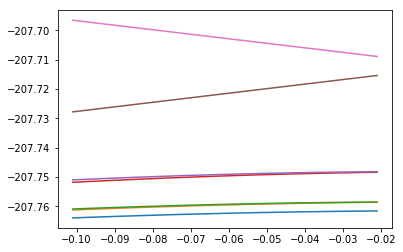

[[-1.01000000e-01 -2.07763940e+02 -2.07761233e+02 -2.07760896e+02
  -2.07751795e+02 -2.07750977e+02 -2.07727780e+02 -2.07696540e+02
  -2.07672811e+02 -2.07672064e+02 -2.07664404e+02 -2.07664103e+02
  -2.07661877e+02 -2.06720090e+02 -2.06719440e+02 -2.06718884e+02
  -2.06718425e+02 -2.06718063e+02 -2.06717800e+02 -2.06652890e+02
  -2.06652300e+02 -2.06651777e+02 -2.06651321e+02 -2.06650934e+02
  -2.06650616e+02 -2.05592891e+02 -2.05590882e+02]
 [-9.60000000e-02 -2.07763705e+02 -2.07760978e+02 -2.07760657e+02
  -2.07751476e+02 -2.07750692e+02 -2.07727004e+02 -2.07697310e+02
  -2.07673092e+02 -2.07672375e+02 -2.07664639e+02 -2.07664351e+02
  -2.07662106e+02 -2.06718420e+02 -2.06717771e+02 -2.06717216e+02
  -2.06716757e+02 -2.06716394e+02 -2.06716130e+02 -2.06654547e+02
  -2.06653955e+02 -2.06653431e+02 -2.06652975e+02 -2.06652588e+02
  -2.06652272e+02 -2.05592553e+02 -2.05590520e+02]
 [-9.10000000e-02 -2.07763481e+02 -2.07760734e+02 -2.07760428e+02
  -2.07751169e+02 -2.07750421e+02 -2.077

In [53]:
#
## Graphical representation of levels
#

ene_prev_f = path + "simpre_prev.ene"
#ene_f = path + "simpre.ene"
ene_prev = np.loadtxt(ene_prev_f, dtype= float)

plt.plot(ene_prev[:,0], ene_prev[:,[1,2,3,4,5,6,7]])
#plt.plot(ene[:,0], ene[:,1:])
#plt.savefig('plot_prev.png', dpi = 300)
plt.show()



In [64]:
#
## Adjust levels to a polinomial expression
#

poli_out = open(path + 'poli.out', 'w')

lvls_list = []
for i in list(range(np.size(ene, axis=1)-1)):
    lvls_list.append('lvl_'+ str(i+1))

ene_df = pd.DataFrame(data=ene[0:,1:],  index=ene[0:,0] , columns=lvls_list)


## Defining polynomia from Prev dataset
c = 0

poli_out.write('name\tk0\tk1\tk2\n') 

for i in ene_df:
    c += 1
    x = ene_df.index#[0:5]
    y = ene_df[i]#.iloc[0:5]
    z = np.polyfit(x, y, deg = 2)
    
    k0 = z[2]
    k1 = z[1]
    k2 = z[0]
    
    #print '>> ' + i + ':'
    #print z
    
    if abs(z[0]) > abs(z[1]):
        m = 'second order higher'
    else:
        m = 'first order higher'
    
    p = np.poly1d(z)
    #print p
    #print '\n'
    
    poli_out.write(i + '\t' + str(k0) + '\t' + str(k1) + '\t' + str(k2))

    poli_out.write('\n')
poli_out.close()

In [75]:
#
##
### Loading datasets
##
#

# Levels list
lvls_list = []
for i in list(range(np.size(ene, axis=1)-1)):
    lvls_list.append('lvl_'+ str(i+1))


# Load polynomios file
with open(path + 'poli.out', 'r') as poli_f:
    poli_df = pd.read_csv(poli_f, sep='\t', header=0, index_col=0)#, dtype=float)



# Load new 'simpre.ene' file with energies of each level at diff H field
with open(path + 'simpre.ene', 'r') as ene_f:
    ene = np.loadtxt(ene_f, dtype= float)
    ene_df = pd.DataFrame(data=ene[0:,1:],  index=ene[0:,0] , columns=lvls_list)

if float(0.0) in ene_df.index:
    ene_df = ene_df.drop([0.0])
    

#print ene_df


#
##
### Prediction of points
##
#
order_f = open('order.dat', 'w')
#order_f.write('H\')

c = 0
H_values = ene_df.index
expected_values = {}


for i in H_values:
    
    order_f.write(str(i) + '\t')
    
    c += 1
    
    for i2 in poli_df.index:
        
        if c == 1:
        
            for i3 in ene_df.loc[i]:
                #lvl = ene_df.loc[i].
                order_f.write(i2 + '\t')
            order_f.write(i2 + '\n')
        
        else:
        
            k0 = poli_df.loc[i2].loc['k0']
            k1 = poli_df.loc[i2].loc['k1']
            k2 = poli_df.loc[i2].loc['k2']
        
            #predicted_E = (k2[i] * (float(i)**2)) + (k1[i] * float(i)) + k0[i]
        
        
    
    
    ## Condition 1 : compare pends (k1)
    
    ## Condition 2 : compare second derivative (k2)
    
    ## Condition 3 : allowed transition (+/- 1)
    
